In [1]:
import sys
import os

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import scipy
import scipy.stats as st
from scipy.optimize import minimize

%matplotlib inline

# Import data

In [12]:
path_data = os.path.join("data", "processed_2_small.csv")

In [13]:
%%time
df = pd.read_csv(path_data, sep=";")
print "# rows: {}".format(len(df))

# rows: 999996
Wall time: 1.97 s


In [14]:
df.dtypes

BETRIEBSTAG            object
FAHRT_BEZEICHNER       object
BETREIBER_ID           object
VERKEHRSMITTEL_TEXT    object
BPUIC                   int64
ANKUNFTSZEIT           object
AN_PROGNOSE            object
ABFAHRTSZEIT           object
AB_PROGNOSE            object
dtype: object

In [15]:
dateparser_ddmmyyy = '%d.%m.%Y'
dateparser_ddmmyyHHMM = '%d.%m.%Y %H:%M'
dateparser_ddmmyyHHMMSS = '%d.%m.%Y %H:%M:%S'

In [16]:
%%time
df["BETRIEBSTAG"] = pd.to_datetime(df["BETRIEBSTAG"], format=dateparser_ddmmyyy)
df["ANKUNFTSZEIT"] = pd.to_datetime(df["ANKUNFTSZEIT"], format=dateparser_ddmmyyHHMM)
df["AN_PROGNOSE"] = pd.to_datetime(df["AN_PROGNOSE"], format=dateparser_ddmmyyHHMMSS)
df["ABFAHRTSZEIT"] = pd.to_datetime(df["ABFAHRTSZEIT"], format=dateparser_ddmmyyHHMM)
df["AB_PROGNOSE"] = pd.to_datetime(df["AB_PROGNOSE"], format=dateparser_ddmmyyHHMMSS)

Wall time: 21.5 s


In [17]:
df.dtypes

BETRIEBSTAG            datetime64[ns]
FAHRT_BEZEICHNER               object
BETREIBER_ID                   object
VERKEHRSMITTEL_TEXT            object
BPUIC                           int64
ANKUNFTSZEIT           datetime64[ns]
AN_PROGNOSE            datetime64[ns]
ABFAHRTSZEIT           datetime64[ns]
AB_PROGNOSE            datetime64[ns]
dtype: object

In [18]:
df.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE
0,2018-03-10,80:807000:19700:002,80:807000,RB,8503424,2018-03-10 05:54:00,2018-03-10 05:55:40,NaT,NaT
1,2018-03-10,80:807000:19701:001,80:807000,S,8503424,NaT,NaT,2018-03-10 05:28:00,2018-03-10 05:28:56
2,2018-03-10,80:807000:19702:004,80:807000,RB,8503424,2018-03-10 06:24:00,2018-03-10 06:24:49,NaT,NaT
3,2018-03-10,80:807000:19703:005,80:807000,S,8503424,NaT,NaT,2018-03-10 06:07:00,2018-03-10 06:07:35
4,2018-03-10,80:807000:19704:007,80:807000,RB,8503424,2018-03-10 06:54:00,2018-03-10 06:55:39,NaT,NaT


In [19]:
df["VERSPAETUNG_AN"] = df["AN_PROGNOSE"] - df["ANKUNFTSZEIT"]
df["VERSPAETUNG_AB"] = df["AB_PROGNOSE"] - df["ABFAHRTSZEIT"]

In [20]:
df.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE,VERSPAETUNG_AN,VERSPAETUNG_AB
0,2018-03-10,80:807000:19700:002,80:807000,RB,8503424,2018-03-10 05:54:00,2018-03-10 05:55:40,NaT,NaT,00:01:40,NaT
1,2018-03-10,80:807000:19701:001,80:807000,S,8503424,NaT,NaT,2018-03-10 05:28:00,2018-03-10 05:28:56,NaT,00:00:56
2,2018-03-10,80:807000:19702:004,80:807000,RB,8503424,2018-03-10 06:24:00,2018-03-10 06:24:49,NaT,NaT,00:00:49,NaT
3,2018-03-10,80:807000:19703:005,80:807000,S,8503424,NaT,NaT,2018-03-10 06:07:00,2018-03-10 06:07:35,NaT,00:00:35
4,2018-03-10,80:807000:19704:007,80:807000,RB,8503424,2018-03-10 06:54:00,2018-03-10 06:55:39,NaT,NaT,00:01:39,NaT


# Overal arrival and departure delay

In [21]:
%%time
df_an_versp = df["VERSPAETUNG_AN"].dropna().apply(lambda d: d.total_seconds() / 60.0)
print "# non-null arr-delays: {}".format(len(df_an_versp))

# non-null arr-delays: 882207
Wall time: 6.95 s


In [22]:
left = -5.0
right = 15.00000001
step = 0.25

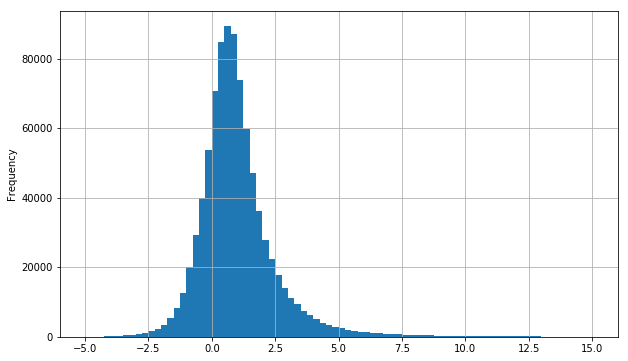

In [23]:
an_range = np.arange(left, right, step)
df_an_versp.plot.hist(bins=an_range, figsize=(10, 6), grid=True)

In [24]:
df_ab_versp = df["VERSPAETUNG_AB"].dropna().apply(lambda d: d.total_seconds() / 60.0)
print "# non-null dep-delays: {}".format(len(df_ab_versp))

# non-null dep-delays: 903100


In [25]:
df_ab_versp.head(15)

1     0.933333
3     0.583333
5     0.466667
7     0.500000
9     0.600000
11    0.633333
13    0.416667
15    0.600000
17    0.466667
19    0.683333
21    0.550000
23    0.483333
25    0.466667
27    0.516667
29    0.333333
Name: VERSPAETUNG_AB, dtype: float64

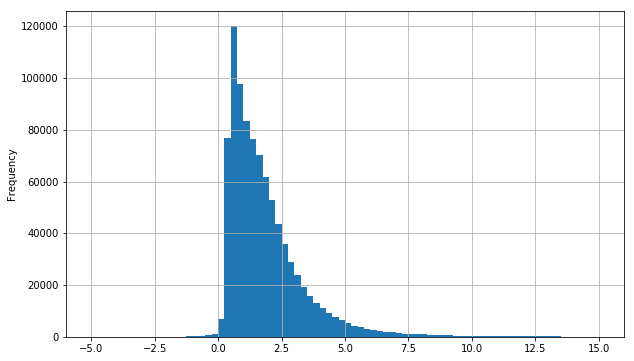

In [26]:
ab_range = np.arange(left, right, step)
df_ab_versp.plot.hist(bins=ab_range, figsize=(10, 6), grid=True)

# Grouping

In [27]:
df.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE,VERSPAETUNG_AN,VERSPAETUNG_AB
0,2018-03-10,80:807000:19700:002,80:807000,RB,8503424,2018-03-10 05:54:00,2018-03-10 05:55:40,NaT,NaT,00:01:40,NaT
1,2018-03-10,80:807000:19701:001,80:807000,S,8503424,NaT,NaT,2018-03-10 05:28:00,2018-03-10 05:28:56,NaT,00:00:56
2,2018-03-10,80:807000:19702:004,80:807000,RB,8503424,2018-03-10 06:24:00,2018-03-10 06:24:49,NaT,NaT,00:00:49,NaT
3,2018-03-10,80:807000:19703:005,80:807000,S,8503424,NaT,NaT,2018-03-10 06:07:00,2018-03-10 06:07:35,NaT,00:00:35
4,2018-03-10,80:807000:19704:007,80:807000,RB,8503424,2018-03-10 06:54:00,2018-03-10 06:55:39,NaT,NaT,00:01:39,NaT


In [28]:
%%time
df["TRAIN_ID"] = df["FAHRT_BEZEICHNER"].apply(lambda x: ":".join(x.split(":")[:-1]))

Wall time: 668 ms


In [29]:
df.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE,VERSPAETUNG_AN,VERSPAETUNG_AB,TRAIN_ID
0,2018-03-10,80:807000:19700:002,80:807000,RB,8503424,2018-03-10 05:54:00,2018-03-10 05:55:40,NaT,NaT,00:01:40,NaT,80:807000:19700
1,2018-03-10,80:807000:19701:001,80:807000,S,8503424,NaT,NaT,2018-03-10 05:28:00,2018-03-10 05:28:56,NaT,00:00:56,80:807000:19701
2,2018-03-10,80:807000:19702:004,80:807000,RB,8503424,2018-03-10 06:24:00,2018-03-10 06:24:49,NaT,NaT,00:00:49,NaT,80:807000:19702
3,2018-03-10,80:807000:19703:005,80:807000,S,8503424,NaT,NaT,2018-03-10 06:07:00,2018-03-10 06:07:35,NaT,00:00:35,80:807000:19703
4,2018-03-10,80:807000:19704:007,80:807000,RB,8503424,2018-03-10 06:54:00,2018-03-10 06:55:39,NaT,NaT,00:01:39,NaT,80:807000:19704


In [30]:
%%time
gpd = df.groupby(["TRAIN_ID", "BPUIC"])

Wall time: 145 ms


In [33]:
d = gpd.groups

In [56]:
df_tt = df[["TRAIN_ID", "BPUIC", "ANKUNFTSZEIT", "ABFAHRTSZEIT", "BETRIEBSTAG"]].groupby(["TRAIN_ID", "BPUIC"]).agg({"ANKUNFTSZEIT": min, "ABFAHRTSZEIT": min, "BETRIEBSTAG": len}).reset_index().sort_values(by=["TRAIN_ID", "ABFAHRTSZEIT", "ANKUNFTSZEIT"])
df_tt = df_tt.rename(columns={"BETRIEBSTAG": "COUNT"})
df_tt = df_tt[["TRAIN_ID", "BPUIC", "ANKUNFTSZEIT", "ABFAHRTSZEIT", "COUNT"]]

In [59]:
df_tt.to_csv(os.path.join("data", "train_bp_uic_counts.csv"), sep=";", index=False)

# Optimization

## Distributions

In [ ]:
dist_names_large = [
    'alpha',
    'anglit',
    'arcsine',
    'beta',
    'betaprime',
    'bradford',
    'burr',
    'cauchy',
    'chi',
    'chi2',
    'cosine',
    'dgamma',
    'dweibull',
    'erlang',
    'expon',
    'exponnorm',
    'exponweib',
    'exponpow',
    'f',
    'fatiguelife',
    'fisk',
    'foldcauchy',
    'foldnorm',
    'frechet_r',
    'frechet_l',
    'genlogistic',
    'genpareto',
    'gennorm',
    'genexpon',
    'genextreme',
#     'gausshyper',
    'gamma',
    'gengamma',
    'genhalflogistic',
    'gilbrat',
    'gompertz',
    'gumbel_r',
    'gumbel_l',
    'halfcauchy',
    'halflogistic',
    'halfnorm',
    'halfgennorm',
    'hypsecant',
    'invgamma',
    'invgauss',
    'invweibull',
    'johnsonsb',
    'johnsonsu',
    'ksone',
    'kstwobign',
    'laplace',
    'levy',
    'levy_l',
#     'levy_stable',
    'logistic',
    'loggamma',
    'loglaplace',
    'lognorm',
    'lomax',
    'maxwell',
    'mielke',
    'nakagami',
    'ncx2',
#     'ncf',
    'nct',
    'norm',
    'pareto',
    'pearson3',
    'powerlaw',
    'powerlognorm',
    'powernorm',
#     'rdist',
    'reciprocal',
    'rayleigh',
    'rice',
    'recipinvgauss',
    'semicircular',
    't',
    'triang',
    'truncexpon',
    'truncnorm',
    'tukeylambda',
    'uniform',
    'vonmises',
    'vonmises_line',
    'wald',
    'weibull_min',
    'weibull_max',
    'wrapcauchy',
]

In [ ]:
dist_names_small = [
    'norm', 
    'lognorm',
    'weibull_min',
     'weibull_max',
    'alpha',
    'cauchy',
    'powerlognorm',
    'chi',
    'erlang',
    'expon',
    'gamma',
    'gumbel_r',
    'halfcauchy',
    'maxwell',
    'wald',
    'levy',
    'levy_l',
    'pareto',
]


## Definition

In [ ]:
def optimize(dist_name, data, opt_type='kst'):
    dist = getattr(scipy.stats, dist_name)
    first_guess = dist.fit(data)
    def fun_eval(act_paras, opt_type=opt_type):
        if opt_type == 'kst':
            d, p = scipy.stats.kstest(data, dist_name, act_paras)
            return d
        elif opt_type == 'cst':
            left = -5.0
            right = 10.0000000000000001
            step = 0.25
            r = np.arange(left, right, step)
            hist_emp = np.histogram(data, r, density=True)[0]
            r_m = np.array([(r[i] + r[i + 1]) / 2.0 for i in range(len(r) - 1)])
            hist_exp = dist.pdf(r_m, *act_paras[:-2], loc=act_paras[-2], scale=act_paras[-1])
            return st.chisquare(hist_emp, f_exp=hist_exp).statistic
        elif opt_type == 'ss':
            left = -5.0
            right = 10.0000000000000001
            step = 0.25
            r = np.arange(left, right, step)
            hist_emp = np.histogram(data, r, density=True)[0]
            r_m = np.array([(r[i] + r[i + 1]) / 2.0 for i in range(len(r) - 1)])
            hist_exp = dist.pdf(r_m, *act_paras[:-2], loc=act_paras[-2], scale=act_paras[-1])
            return np.power(hist_emp - hist_exp, 2.0).sum()
        elif opt_type == 'as':
            left = -5.0
            right = 10.0000000000000001
            step = 0.25
            r = np.arange(left, right, step)
            hist_emp = np.histogram(data, r, density=True)[0]
            r_m = np.array([(r[i] + r[i + 1]) / 2.0 for i in range(len(r) - 1)])
            hist_exp = dist.pdf(r_m, *act_paras[:-2], loc=act_paras[-2], scale=act_paras[-1])
            return np.absolute(hist_emp - hist_exp).sum()
        else:
            raise ValueError("{} is not a valid argument".format(opt_type))
    opt_paras = minimize(fun_eval, first_guess, method='nelder-mead')
    return opt_paras

In [ ]:
def evaluate(data, dist_names=dist_names_large, left=left, right=right, step=step, plot_best_n=5):
    # plot data
    x = np.arange(left, right, step)
    y = np.array(data)
    plt.figure(figsize=(13,9))
    h = plt.hist(y, bins=x, color='black', density=False)

    # optimization per distribution
    res_per_dist_name = {}
    for dist_name in dist_names:
        print dist_name
        try:
            res = optimize(dist_name, y, opt_type='as')
            res_per_dist_name[dist_name] = res
            param = res.x
        except Exception as e:
            print "no success: {}".format(e)

    # plot best distributions
    sorted_dist_name_res_pairs = sorted(res_per_dist_name.items(), key=lambda p: p[1].fun)
    x_dist=np.arange(left, right, 0.05)
    for dist_name, res in sorted_dist_name_res_pairs[:plot_best_n]:
            dist = getattr(scipy.stats, dist_name)
            param = res.x
            pdf_fitted = dist.pdf(x_dist, *param[:-2], loc=param[-2], scale=param[-1]) * h[0].sum() * step
            plt.plot(x_dist, pdf_fitted, label="{} {:.4f} {}".format(dist_name, res.fun, res.success))
    plt.xlim(x[0], x[-1])
    plt.legend(loc='upper right')
    plt.show()

## Analysis

In [ ]:
def evaluate_arr_train_stop(train_id, bpuic, **kargs):
    data = df[(df["TRAIN_ID"] == train_id) & (df["BPUIC"] == bpuic)]["VERSPAETUNG_AN"].dropna().apply(lambda d: d.total_seconds() / 60.0)
    print len(data)
    evaluate(data, **kargs)

In [ ]:
evaluate_arr_train_stop("85:11:2528", 8507000, step=0.5)